# intro

In [ ]:
!pip install numpy
!pip install pandas
!pip install seaborn
!pip show scipy

In [91]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr, chisquare, shapiro, normaltest, norm
from sklearn.preprocessing import LabelEncoder

orig_data = pd.read_csv('Esophageal_Dataset.csv')

# overweight

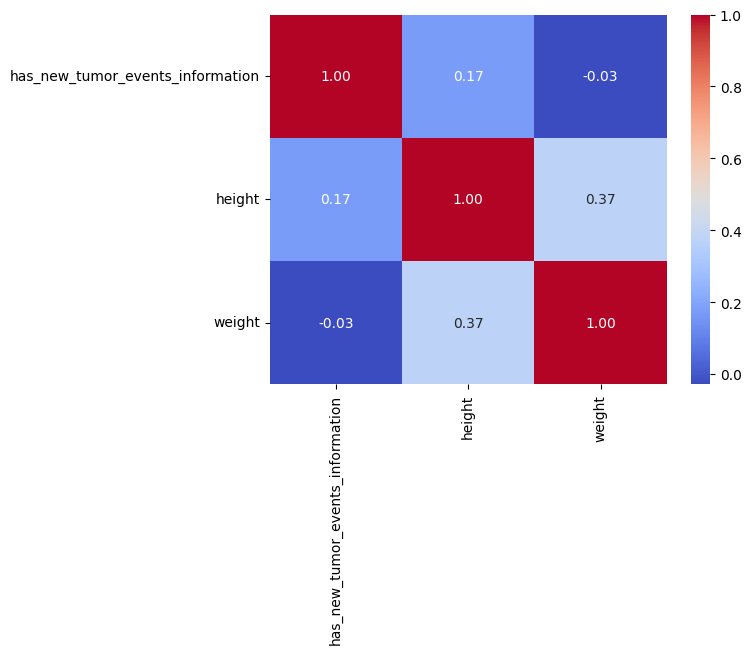

In [57]:
df = orig_data[['patient_id', 'has_new_tumor_events_information', 'height', 'weight']].copy()
df['height'] = pd.to_numeric(df['height'], errors='coerce')
df['weight'] = pd.to_numeric(df['weight'], errors='coerce')
df = df.dropna(subset=['height', 'weight'])
df['has_new_tumor_events_information'] = df['has_new_tumor_events_information'].str.lower().map({'yes': 1, 'no': 0})
df = df.groupby('patient_id').agg({
    'has_new_tumor_events_information': 'max',
    'height': 'mean',
    'weight': 'mean'}).reset_index()
df = df.drop(columns=['patient_id'])
correlation_matrix = df.corr('pearson')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()
# df.loc[:, 'BMI'] = df['weight'] / ((df['height'] / 100) ** 2)
# correlation_matrix = df.corr()
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
# plt.show()
# def categorize_bmi(bmi):
#     if bmi < 18.5:
#         return 'Underweight'
#     elif 18.5 <= bmi < 25:
#         return 'Normal'
#     elif 25 <= bmi < 30:
#         return 'Overweight'
#     else:
#         return 'Obese'

# df['BMI_Category'] = df['BMI'].apply(categorize_bmi)

# # Cross-tabulation
# bmi_diagnosis_table = pd.crosstab(df['BMI_Category'], df['Diagnosis'])
# print(bmi_diagnosis_table)

# # Visualize
# sns.heatmap(bmi_diagnosis_table, annot=True, cmap='Blues')
# plt.title('BMI Category vs Diagnosis')
# plt.show()

# general

In [43]:

df = orig_data.copy()
df_sorted = df.sort_values(by='patient_id')

# Check for changes in each column
# You can do this by comparing consecutive rows for the same 'patient_id'
columns_with_changes = []

for column in df.columns:
    if column != 'patient_id':  # Skip the 'patient_id' column itself
        # Check if there are any changes in this column for the same 'patient_id'
        changes = df_sorted.groupby('patient_id')[column].apply(lambda x: x.nunique() > 1)
        if changes.any():  # If there are any changes, add the column to the list
            columns_with_changes.append(column)

# Display columns that have changes for the same 'patient_id'
print("Columns with changes for the same 'patient_id':")
print(columns_with_changes)

Columns with changes for the same 'patient_id':
['Unnamed: 0', 'patient_barcode', 'days_to_birth', 'height', 'weight']


In [63]:
df = orig_data.copy()
columns_of_interest = ['height', 'weight', 'days_to_birth']
max_min_diff_multiple_columns = df.groupby('patient_id')[columns_of_interest].agg(lambda x: x.max() - x.min())
print(max_min_diff_multiple_columns)
max_diff_per_column = max_min_diff_multiple_columns.max()
print(max_diff_per_column)
min_diff_per_column = max_min_diff_multiple_columns.min()
print(min_diff_per_column)

            height  weight  days_to_birth
patient_id                               
A3I8          10.0    10.0            165
A3QL           9.0     7.0            170
A3Y9          10.0    10.0            194
A3YA          10.0     9.0            192
A3YB          10.0     9.0            179
...            ...     ...            ...
AAAR           9.0    10.0            197
AAPN          10.0    10.0            181
AASV           7.0    10.0            190
AASW          10.0    10.0            182
AASX           8.0     7.0            191

[185 rows x 3 columns]
height            10.0
weight            10.0
days_to_birth    200.0
dtype: float64
height             7.0
weight             7.0
days_to_birth    139.0
dtype: float64


In [66]:
df = orig_data.copy()
visit_count = df['patient_id'].value_counts().unique()
print(visit_count)

# Define the columns of interest
columns_of_interest = ['height', 'weight', 'days_to_birth']

# Now perform the Chi-squared test for each patient_id in each column
chi2_results = {}

for column in columns_of_interest:
    chi2_results[column] = {}

    for patient_id, group_data in df.groupby('patient_id')[column]:
        # Bin the data for each patient
        bins = np.histogram(group_data.dropna(), bins=10)[0]  # Adjust bins if needed

        # Perform the Chi-squared test for the binned data
        chi2_stat, p_value = chisquare(bins)

        # Store the results
        chi2_results[column][patient_id] = {
            'Chi2': chi2_stat,
            'p-value': p_value
        }

# Print the Chi-squared test results for each patient
for column in chi2_results:
    print(f"\nChi-squared results for {column}:")
    for patient_id, result in chi2_results[column].items():
        visit_count = df[df['patient_id'] == patient_id].shape[0]
        print(f"Patient ({patient_id}), gender: {df.loc[df['patient_id'] == patient_id, 'gender'].iloc[0]}, visit count {visit_count} - Chi2: {result['Chi2']}, p-value: {result['p-value']}")


[39 20]


c:\Users\dauma\Desktop\codeacademy\uzd_dataset_1\.venv\Lib\site-packages\scipy\stats\_stats_py.py:7654: RuntimeWarning: invalid value encountered in divide
  terms = (f_obs - f_exp)**2 / f_exp
c:\Users\dauma\Desktop\codeacademy\uzd_dataset_1\.venv\Lib\site-packages\scipy\stats\_stats_py.py:7654: RuntimeWarning: invalid value encountered in divide
  terms = (f_obs - f_exp)**2 / f_exp



Chi-squared results for height:
Patient (A3I8), gender: FEMALE, visit count 20 - Chi2: 7.0, p-value: 0.6371194071693982
Patient (A3QL), gender: MALE, visit count 20 - Chi2: 15.0, p-value: 0.09093597657980511
Patient (A3Y9), gender: MALE, visit count 20 - Chi2: 3.0, p-value: 0.9642949726850891
Patient (A3YA), gender: MALE, visit count 20 - Chi2: 13.0, p-value: 0.16260626219029953
Patient (A3YB), gender: MALE, visit count 20 - Chi2: 11.0, p-value: 0.27570893677222197
Patient (A3YC), gender: MALE, visit count 20 - Chi2: 7.0, p-value: 0.6371194071693982
Patient (A43C), gender: MALE, visit count 20 - Chi2: 5.0, p-value: 0.8343082601934075
Patient (A43E), gender: MALE, visit count 20 - Chi2: 11.0, p-value: 0.27570893677222197
Patient (A43H), gender: MALE, visit count 20 - Chi2: 11.0, p-value: 0.27570893677222197
Patient (A43I), gender: MALE, visit count 39 - Chi2: 16.64102564102564, p-value: 0.05464336462012305
Patient (A43J), gender: MALE, visit count 39 - Chi2: 6.384615384615385, p-value:

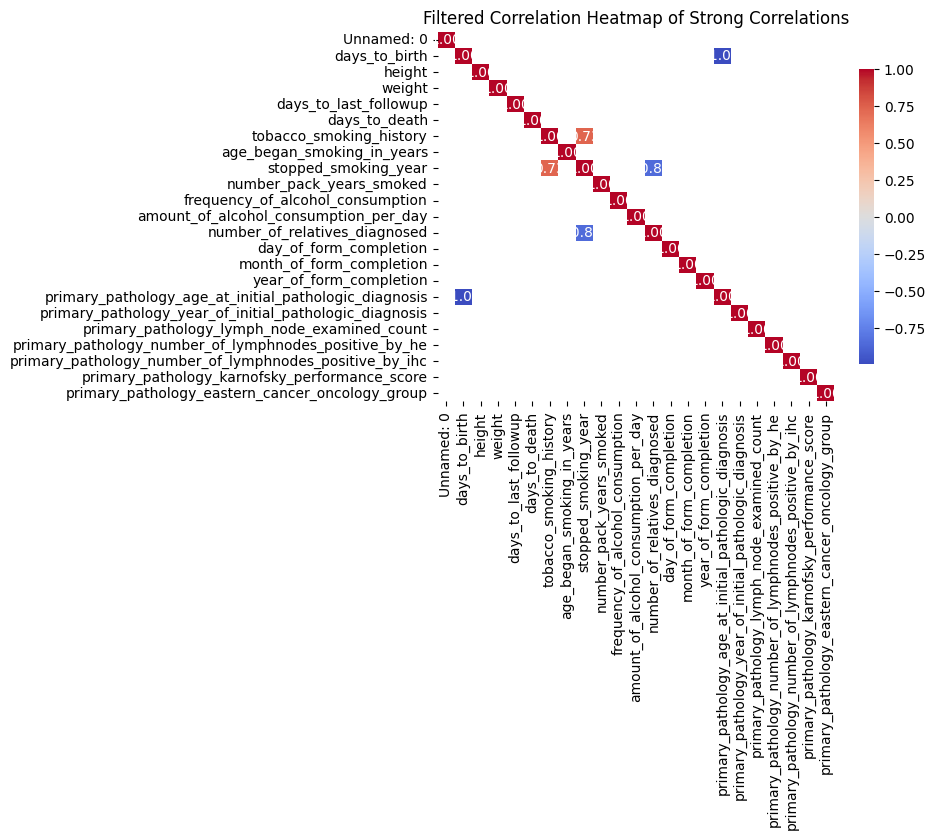

In [ ]:

df = orig_data.apply(pd.to_numeric, errors='coerce')
numerical_df = df.select_dtypes(include=['float64', 'int64'])
threshold = 0.7
correlation_matrix = numerical_df.corr()
strong_correlations = correlation_matrix[abs(correlation_matrix) >= threshold]
mask = abs(correlation_matrix) >= threshold
filtered_corr = correlation_matrix[mask].dropna(axis=0, how='all').dropna(axis=1, how='all')
sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={"shrink": .8})
plt.title("Filtered Correlation Heatmap of Strong Correlations")
plt.show()

# analysis height

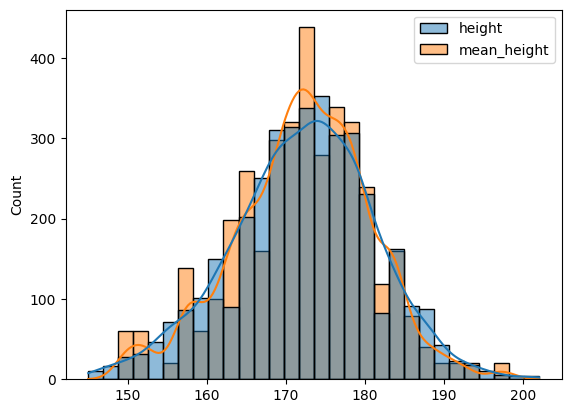

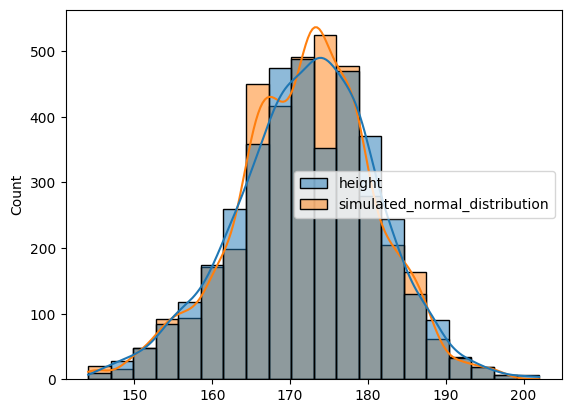

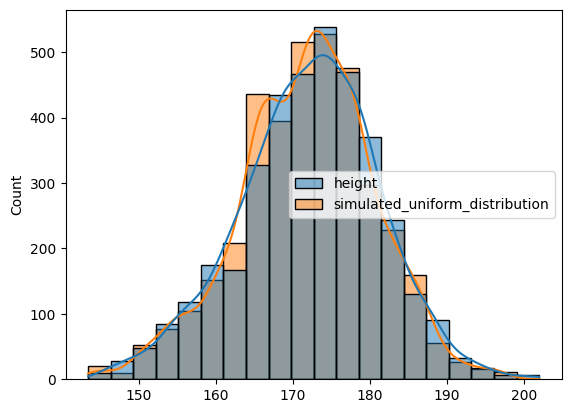

In [ ]:
df = orig_data[['patient_id', 'height']].sort_values(by='patient_id').copy()
df = df[pd.to_numeric(df['height'], errors='coerce').between(140, 210)]
df = df.dropna(subset=['height'])
df['base_height'] = df.groupby('patient_id')['height'].transform(lambda x: x.max() - (x.max() - x.min()) / 2)
df['mean_height'] = df.groupby('patient_id')['height'].transform('mean')
df['height_diff'] = df['base_height'] - df['mean_height']
# print(df)

sns.histplot(df[['height', 'mean_height']], kde=True, bins=30)
plt.show()

normal_mean, normal_std = norm.fit(df['height_diff'])
uniform_low, uniform_high = df['height_diff'].min(), df['height_diff'].max()
simulated_normal = []
simulated_uniform = []
for patient_id, group in df.groupby('patient_id'):
    base_height = group['height'].iloc[0]
    num_visits = len(group)
    normal_heights = base_height + np.random.normal(loc=normal_mean, scale=normal_std, size=num_visits)
    uniform_heights = base_height + np.random.uniform(low=uniform_low, high=uniform_high, size=num_visits)
    simulated_normal.extend(normal_heights)
    simulated_uniform.extend(uniform_heights)
df['simulated_normal_distribution'] = simulated_normal
df['simulated_uniform_distribution'] = simulated_uniform
sns.histplot(df[['height', 'simulated_normal_distribution']], kde=True, bins=20)
plt.show()
sns.histplot(df[['height', 'simulated_uniform_distribution']], kde=True, bins=20)
plt.show()